# Bayesian black-box model-predictive control

An Expected Free Energy minimizing agent based on a nonlinear autoregressive model with exogenous input.

## System: NARX

Consider a system generating observations $y_k \in \mathbb{R}$ based on inputs $u_k \in \mathbb{R}$:

$$ y_k = \theta_1 y_{k-1} + \theta_2 u_k  \, ,$$

In [1]:
using Pkg
Pkg.activate("..")
Pkg.instantiate();

  Activating project at `~/syndr/Wouter/Onderzoek/Projecten/tue/efe-acquisition/ACC2024-NARXEFE`


In [2]:
using Revise
using FFTW
using DSP
using ForwardDiff
using Optim
using RxInfer
using LaTeXStrings
using SpecialFunctions
using LinearAlgebra
using ProgressMeter
using Distributions
using Plots; default(grid=false, label="", linewidth=3, margin=20Plots.pt)

includet("../NARXAgents.jl"); using .NARXAgents
includet("../NARXsystem.jl"); using .NARXsystem
includet("../mv_normal_gamma.jl"); using .mv_normal_gamma 
includet("../location_scale_tdist.jl"); using .location_scale_tdist

In [3]:
# Time
N = 10
fs = 10 # Hertz
Δt = 1/fs
tsteps = collect(range(0.0, step=Δt, length=N));

# Planning horizon
T = 1;

In [4]:
# Define system parameters
sys_mnoise_sd = 0.0;
input_lims = (-1.,1.)

H = 1
sys_basis(x) = cat([x.^d for d in 1:H]...,dims=1)

M_in = 0
M_out = 1
M = length(sys_basis(zeros(M_in + M_out + 1)))
sys_coefficients = [0.5, -0.5]

2-element Vector{Float64}:
  0.5
 -0.5

In [5]:
# Specify prior distributions
α0 = 1e1
β0 = 1e0
μ0 = ones(M)
Λ0 = 0.5diagm(ones(M))
goals = [Normal(0.5, 1.0) for _ in 1:T]

1-element Vector{Normal{Float64}}:
 Normal{Float64}(μ=0.5, σ=1.0)

In [6]:
system = NARXsys(sys_coefficients, 
                 sys_basis,
                 sys_mnoise_sd, 
                 order_outputs=M_out, 
                 order_inputs=M_in)
                 
agent = NARXAgent(μ0, Λ0, α0, β0,
                  goal_prior=goals, 
                  delay_inp=M_in, 
                  delay_out=M_out, 
                  pol_degree=H,
                  zero_order=false,
                  time_horizon=T)

Nu = 500
urange = collect(range(input_lims[1], stop=input_lims[2], length=Nu))

J_mi = [mutualinfo(agent, agent.ybuffer, agent.ubuffer, u_i) for u_i in urange]
J_ce = [crossentropy(agent, agent.ybuffer, agent.ubuffer, goals[1], u_i) for u_i in urange]
J_EFE = [EFE(agent, agent.ybuffer, agent.ubuffer, goals[1], u_i) for u_i in urange]
J_QCR = [QCR(agent, agent.ybuffer, agent.ubuffer, goals[1], u_i) for u_i in urange];

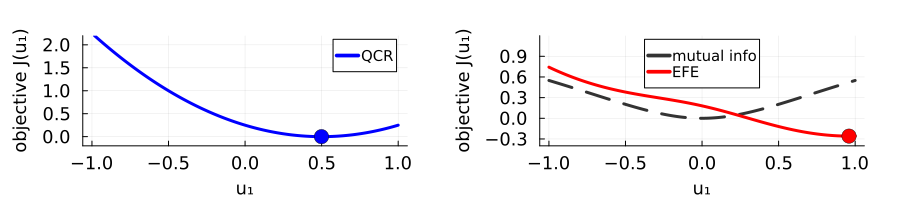

In [7]:
uix_QCR = argmin(J_QCR)
u_QCR = urange[uix_QCR]
uix_EFE = argmin(J_EFE)
u_EFE = urange[uix_EFE]

p101 = plot(grid=true, guidefontsize=12, tickfontsize=12, legendfontsize=10) 
plot!(urange, J_QCR, xlabel="u₁", color="blue", ylabel="objective J(u₁)", ylims=(-0.2, 2.2), label="QCR")
scatter!([u_QCR], [J_QCR[uix_QCR]], markersize=8, color="blue")

p102 = plot(grid=true, guidefontsize=12, tickfontsize=12, legendfontsize=10, ) 
plot!(urange, J_mi, color="black", linestyle=:dash, alpha=0.8, ylims=(-0.4, 1.2), label="mutual info")
plot!(urange, J_EFE, xlabel="u₁", color="red", ylabel="objective J(u₁)", label="EFE")
scatter!([u_EFE], [J_EFE[uix_EFE]], markersize=8,color="red", legend=:top)

plot(p101, p102, layout=(1,2), size=(900,200))

In [8]:
savefig("figures/step-by-step_objectives.png")

"/home/wmkouw/syndr/Wouter/Onderzoek/Projecten/tue/efe-acquisition/ACC2024-NARXEFE/step-by-step/figures/step-by-step_objectives.png"

In [9]:
# Evolve according to QCR action
system = NARXsys(sys_coefficients, 
                 sys_basis,
                 sys_mnoise_sd, 
                 order_outputs=M_out, 
                 order_inputs=M_in)
                 
agent = NARXAgent(μ0, Λ0, α0, β0,
                  goal_prior=goals, 
                  delay_inp=M_in, 
                  delay_out=M_out, 
                  pol_degree=H,
                  zero_order=false,
                  time_horizon=T)

NARXsystem.update!(system, u_QCR)
y_QCR = system.observation
NARXAgents.update!(agent, y_QCR, u_QCR)

α_QCR = agent.α
β_QCR = agent.β
μ_QCR = agent.μ
Λ_QCR = agent.Λ
μ_QCR = agent.μ
Λ_QCR = agent.Λ

y2_QCR = sys_coefficients'*[y_QCR, u_QCR] 

ϕ_t = pol([agent.ybuffer; agent.ubuffer], degree=1, zero_order=false)
ν_QCR, m_QCR, s2_QCR = posterior_predictive(agent, ϕ_t);

In [10]:
# Evolve according to EFE action
system = NARXsys(sys_coefficients, 
                 sys_basis,
                 sys_mnoise_sd, 
                 order_outputs=M_out, 
                 order_inputs=M_in)
                 
agent = NARXAgent(μ0, Λ0, α0, β0,
                  goal_prior=goals, 
                  delay_inp=M_in, 
                  delay_out=M_out, 
                  pol_degree=H,
                  zero_order=false,
                  time_horizon=T)
                  
NARXsystem.update!(system, u_EFE)
y_EFE = system.observation
NARXAgents.update!(agent, y_EFE, u_EFE)

α_EFE = agent.α
β_EFE = agent.β
μ_EFE = agent.μ
Λ_EFE = agent.Λ
μ_EFE = agent.μ
Λ_EFE = agent.Λ

y2_EFE = sys_coefficients'*[y_EFE, u_EFE] 

ϕ_t = pol([agent.ybuffer; agent.ubuffer], degree=1, zero_order=false)
ν_EFE, m_EFE, s2_EFE = posterior_predictive(agent, ϕ_t);

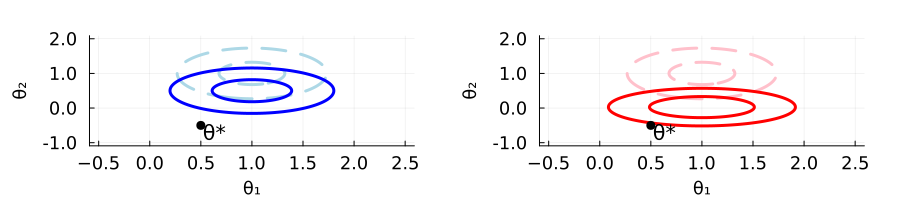

In [11]:
xr1 = range(-.5, stop=2.5, length=100)
xr2 = range(-1, stop=2.0, length=100)

clevels = [0.2, 0.6]

p201 = plot(xlabel="θ₁", ylabel="θ₂", grid=true, guidefontsize=12, tickfontsize=12, legendfontsize=12, yticks=([-1, 0, 1, 2], ["-1.0", "0.0", "1.0", "2.0"]))
contour!( xr1, xr2, (xr1,xr2) -> location_scale_tdist.pdf(MvLocationScaleT(2α0, μ0, inv(α0/β0*Λ0)), [xr1,xr2]), color="lightblue", linestyles=:dash, alpha=1.0, levels=clevels, colorbar=false, label="QCR")
contour!( xr1, xr2, (xr1,xr2) -> location_scale_tdist.pdf(MvLocationScaleT(2α_QCR, μ_QCR, inv(α_QCR/β_QCR*Λ_QCR)), [xr1,xr2]), color="blue", alpha=1.0, levels=clevels, colorbar=false, label="QCR")
scatter!([sys_coefficients[1]], [sys_coefficients[2]], markersize=5, color="black", annotations = (sys_coefficients[1]+0.03, -.7, text.("θ*", :left)))

p202 = plot(xlabel="θ₁", ylabel="θ₂", grid=true, guidefontsize=12, tickfontsize=12, legendfontsize=12, yticks=([-1, 0, 1, 2], ["-1.0", "0.0", "1.0", "2.0"]))
contour!( xr1, xr2, (xr1,xr2) -> location_scale_tdist.pdf(MvLocationScaleT(2α0, μ0, inv(α0/β0*Λ0)), [xr1,xr2]), color="pink", linestyles=:dash, alpha=1.0, levels=clevels, colorbar=false, label="QCR")
contour!(xr1, xr2, (xr1,xr2) -> location_scale_tdist.pdf(MvLocationScaleT(2α_EFE, μ_EFE, inv(α_EFE/β_EFE*Λ_EFE)), [xr1,xr2]), color="red", alpha=1.0, levels=clevels, colorbar=false, label="EFE")
scatter!([sys_coefficients[1]], [sys_coefficients[2]], markersize=5, color="black",annotations = (sys_coefficients[1]+0.03, -.7, text.("θ*", :left)))

plot(p201, p202, layout=(1,2), size=(900,200))

In [12]:
savefig("figures/step-by-step_posteriors.png")

"/home/wmkouw/syndr/Wouter/Onderzoek/Projecten/tue/efe-acquisition/ACC2024-NARXEFE/step-by-step/figures/step-by-step_posteriors.png"

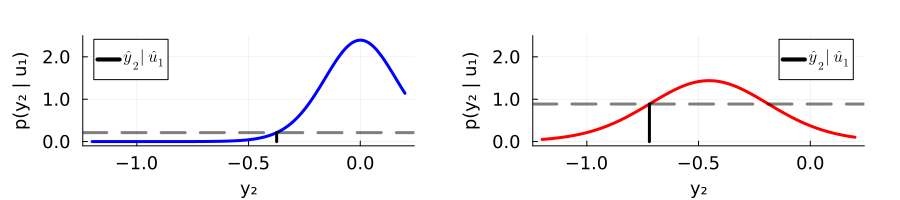

In [13]:
yrange = collect(range(-1.2, stop=0.2, length=500))
yl = (-0.1, 2.5)

QCR_point = location_scale_tdist.pdf.(LocationScaleT(ν_QCR, m_QCR, s2_QCR), y2_QCR)
EFE_point = location_scale_tdist.pdf.(LocationScaleT(ν_EFE, m_EFE, s2_EFE), y2_EFE)

py_QCR = location_scale_tdist.pdf.(LocationScaleT(ν_QCR, m_QCR, s2_QCR), yrange)
py_EFE = location_scale_tdist.pdf.(LocationScaleT(ν_EFE, m_EFE, s2_EFE), yrange)

p301 = plot(grid=true, guidefontsize=12, tickfontsize=12, legendfontsize=11, ylims=yl, xticks=([-1., -.5, 0.0]), yticks=([0.0, 1.0, 2.0], ["0.0", "1.0", "2.0"]), ylabel="p(y₂ | u₁)", xlabel="y₂") 
plot!(yrange, py_QCR, color="blue", label="", legend=:topleft)
plot!([y2_QCR, y2_QCR], [0.0, QCR_point], linewidth=3, label=L"\hat{y}_2 \, | \hat{u}_1", color="black")
hline!([QCR_point], linestyle=:dash, alpha=0.5, color="black")

p302 = plot(grid=true, guidefontsize=12, tickfontsize=12, legendfontsize=11, ylims=yl, xticks=([-1., -.5, 0.0]), yticks=([0.0, 1.0, 2.0], ["0.0", "1.0", "2.0"]), ylabel="p(y₂ | u₁)", xlabel="y₂") 
plot!(yrange, py_EFE, color="red", label="")
plot!([y2_EFE, y2_EFE], [0.0, EFE_point], linewidth=3, label=L"\hat{y}_2 \, | \hat{u}_1", color="black")
hline!([EFE_point], linestyle=:dash, alpha=0.5, color="black")

plot(p301, p302, layout=(1,2), size=(900,200))

In [14]:
savefig("figures/step-by-step_predictions.png")

"/home/wmkouw/syndr/Wouter/Onderzoek/Projecten/tue/efe-acquisition/ACC2024-NARXEFE/step-by-step/figures/step-by-step_predictions.png"

In [15]:
# Specify prior distributions
α0 = 1e1
β0 = 1e0
μ0 = ones(M)
Λ0 = 2diagm(ones(M))
goals = [Normal(0.5, 1.0) for _ in 1:T]

system = NARXsys(sys_coefficients, 
                 sys_basis,
                 sys_mnoise_sd, 
                 order_outputs=M_out, 
                 order_inputs=M_in)
                 
agent = NARXAgent(μ0, Λ0, α0, β0,
                  goal_prior=goals, 
                  delay_inp=M_in, 
                  delay_out=M_out, 
                  pol_degree=H,
                  zero_order=false,
                  time_horizon=T)

Nu = 500
urange = collect(range(input_lims[1], stop=input_lims[2], length=Nu))

J_MI1 = [mutualinfo(agent, agent.ybuffer, agent.ubuffer, u_i) for u_i in urange]
J_EFE1 = [EFE(agent, agent.ybuffer, agent.ubuffer, goals[1], u_i) for u_i in urange];

In [16]:
# Specify prior distributions
α0 = 1e1
β0 = 1e0
μ0 = ones(M)
Λ0 = 1e2diagm(ones(M))
goals = [Normal(0.5, 1.0) for _ in 1:T]

system = NARXsys(sys_coefficients, 
                 sys_basis,
                 sys_mnoise_sd, 
                 order_outputs=M_out, 
                 order_inputs=M_in)
                 
agent = NARXAgent(μ0, Λ0, α0, β0,
                  goal_prior=goals, 
                  delay_inp=M_in, 
                  delay_out=M_out, 
                  pol_degree=H,
                  zero_order=false,
                  time_horizon=T)

Nu = 500
urange = collect(range(input_lims[1], stop=input_lims[2], length=Nu))

J_MI2 = [mutualinfo(agent, agent.ybuffer, agent.ubuffer, u_i) for u_i in urange]
J_EFE2 = [EFE(agent, agent.ybuffer, agent.ubuffer, goals[1], u_i) for u_i in urange];

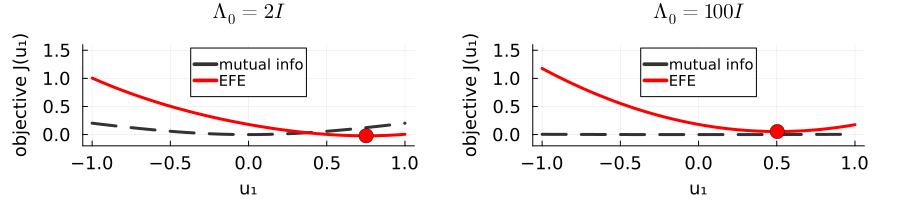

In [17]:
uix_EFE1 = argmin(J_EFE1)
u_EFE1 = urange[uix_EFE1]
uix_EFE2 = argmin(J_EFE2)
u_EFE2 = urange[uix_EFE2]

p101 = plot(grid=true, guidefontsize=12, tickfontsize=12, legendfontsize=10, title=L"Λ_0 = 2 I") 
plot!(urange, J_MI1, color="black", linestyle=:dash, alpha=0.8, ylims=(-0.2, 1.6), label="mutual info")
plot!(urange, J_EFE1, xlabel="u₁", color="red", ylabel="objective J(u₁)", label="EFE")
scatter!([u_EFE1], [J_EFE1[uix_EFE1]], markersize=8,color="red", legend=:top)

p102 = plot(grid=true, guidefontsize=12, tickfontsize=12, legendfontsize=10, title=L"Λ_0 = 100 I") 
plot!(urange, J_MI2, color="black", linestyle=:dash, alpha=0.8, ylims=(-0.2, 1.6), label="mutual info")
plot!(urange, J_EFE2, xlabel="u₁", color="red", ylabel="objective J(u₁)", label="EFE")
scatter!([u_EFE2], [J_EFE2[uix_EFE2]], markersize=8,color="red", legend=:top)

plot(p101, p102, layout=(1,2), size=(900,200))

In [18]:
savefig("figures/step-by-step_lowuncertainty.png")

"/home/wmkouw/syndr/Wouter/Onderzoek/Projecten/tue/efe-acquisition/ACC2024-NARXEFE/step-by-step/figures/step-by-step_lowuncertainty.png"

In [19]:
# Specify prior distributions
α0 = 1e1
β0 = 1e0
μ0 = ones(M)
goals = [Normal(0.5, 1.0) for _ in 1:T]

L = [1e-2 1e-1 1e0 1e1 1e2 1e3]./M
NL = length(L)

Nu = 501
urange = collect(range(input_lims[1], stop=input_lims[2], length=Nu))

JL_MI  = zeros(NL,Nu)
JL_EFE = zeros(NL,Nu)

for (jj,l) in enumerate(L)
                 
    agent = NARXAgent(μ0, l*diagm(ones(M)), α0, β0,
                  goal_prior=goals, 
                  delay_inp=M_in, 
                  delay_out=M_out, 
                  pol_degree=H,
                  zero_order=false,
                  time_horizon=T)

    JL_MI[jj,:] = [mutualinfo(agent, agent.ybuffer, agent.ubuffer, u_i) for u_i in urange]
    JL_EFE[jj,:] = [EFE(agent, agent.ybuffer, agent.ubuffer, goals[1], u_i) for u_i in urange]
end

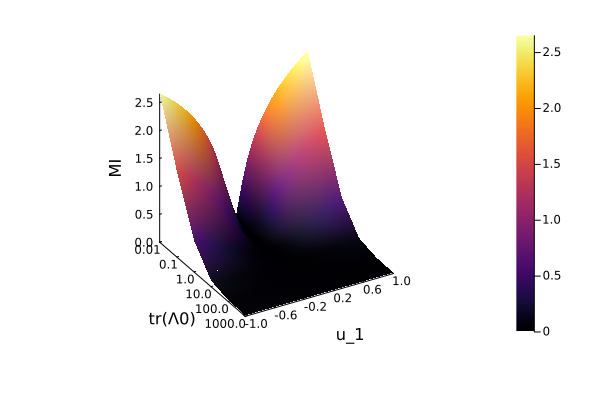

In [21]:
MI_lims = (minimum(JL_MI), maximum(JL_MI))
zlims = MI_lims[1]:2:MI_lims[2]

surface(JL_MI', 
        xticks=(1:NL,L.*M), xlabel="tr(Λ0)", xscale=:log10, 
        yticks=(1:100:Nu, urange[1:100:end]), ylabel="u_1",
        zlabel="MI",
        camera=(60,30))